Using device: cuda
Available breeds: ['Naeimi', 'Najdi', 'Harri', 'Goat', 'Sawakni', 'Roman', 'Barbari']
=== Sheep Classification Pipeline ===
Competition: Eid Al-Adha 2025 - Sheep Classification Challenge
Evaluation Metric: Macro F1 Score
Loading training data...
Training data shape: (682, 2)
Unique breeds: ['Naeimi' 'Goat' 'Roman' 'Harri' 'Sawakni' 'Barbari' 'Najdi']

Breed distribution:
label
Naeimi     255
Goat       107
Sawakni     80
Roman       72
Najdi       71
Harri       62
Barbari     35
Name: count, dtype: int64


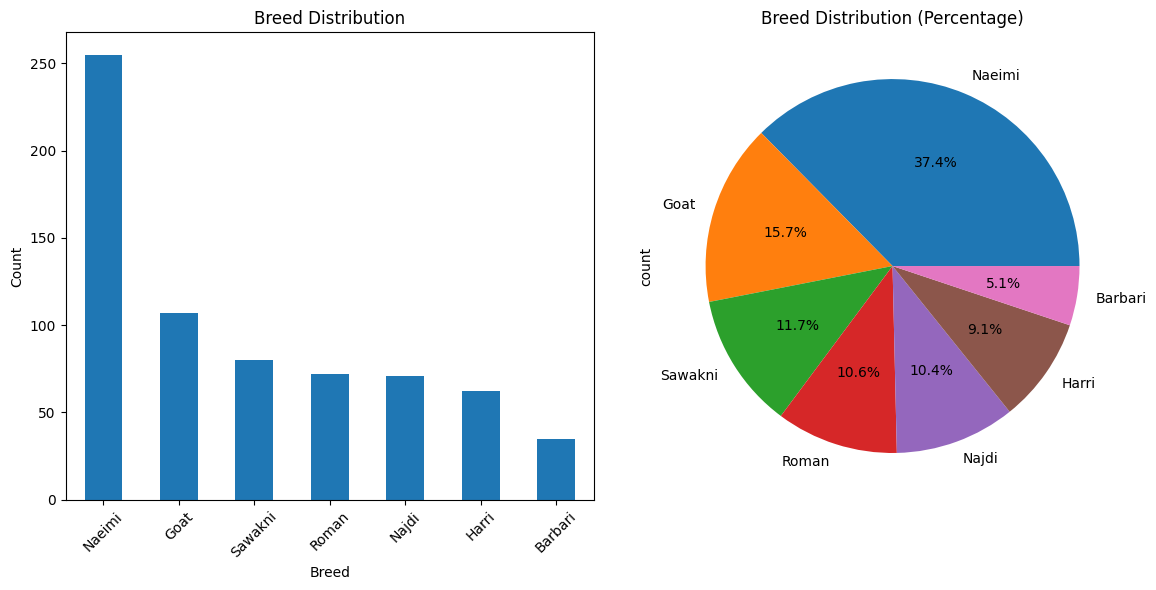


Calculating class weights for imbalanced dataset...

Calculated Class Weights:
  Barbari: 2.7837
  Goat: 0.9105
  Harri: 1.5714
  Naeimi: 0.3821
  Najdi: 1.3722
  Roman: 1.3532
  Sawakni: 1.2179

Class weight tensor shape: torch.Size([7])
Weights will be applied to CrossEntropyLoss
Train split size: 545
Validation split size: 137
Number of training batches: 69
Number of validation batches: 18


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 206MB/s]


Model: EfficientNet-B3
Optimizer: AdamW (lr=0.0001)
Scheduler: CosineAnnealingLR
Loss function: CrossEntropyLoss

Starting training with early stopping...
Epoch 1/75, Batch 0/69, Loss: 1.9597
Epoch 1/75, Batch 20/69, Loss: 1.9215
Epoch 1/75, Batch 40/69, Loss: 1.8767
Epoch 1/75, Batch 60/69, Loss: 1.6791
Epoch 1/75:
  Train Loss: 1.8633
  Val Loss: 1.7062
  Val F1 Score: 0.7707
  New best F1 score: 0.7707
  Learning Rate: 0.000100
--------------------------------------------------
Epoch 2/75, Batch 0/69, Loss: 1.4776
Epoch 2/75, Batch 20/69, Loss: 1.3722
Epoch 2/75, Batch 40/69, Loss: 0.8553
Epoch 2/75, Batch 60/69, Loss: 1.3273
Epoch 2/75:
  Train Loss: 1.1997
  Val Loss: 0.7113
  Val F1 Score: 0.8292
  New best F1 score: 0.8292
  Learning Rate: 0.000100
--------------------------------------------------
Epoch 3/75, Batch 0/69, Loss: 0.7725
Epoch 3/75, Batch 20/69, Loss: 0.2185
Epoch 3/75, Batch 40/69, Loss: 0.7308
Epoch 3/75, Batch 60/69, Loss: 0.5200
Epoch 3/75:
  Train Loss: 0.5982

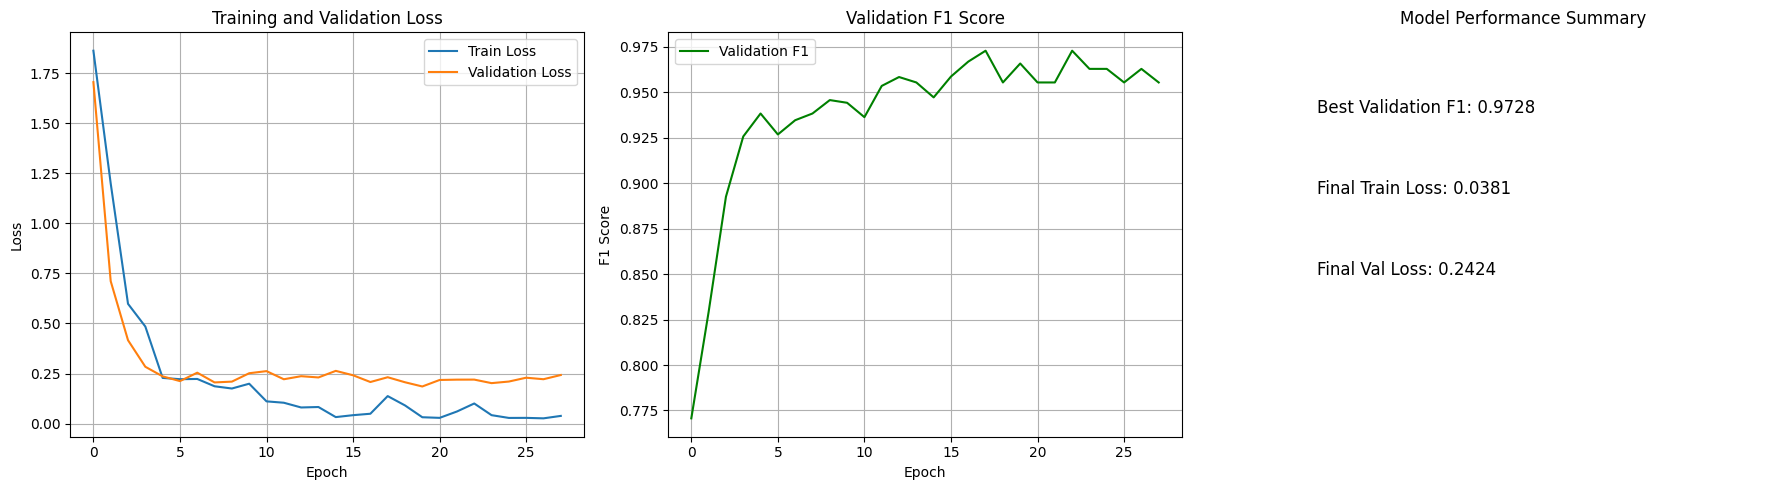

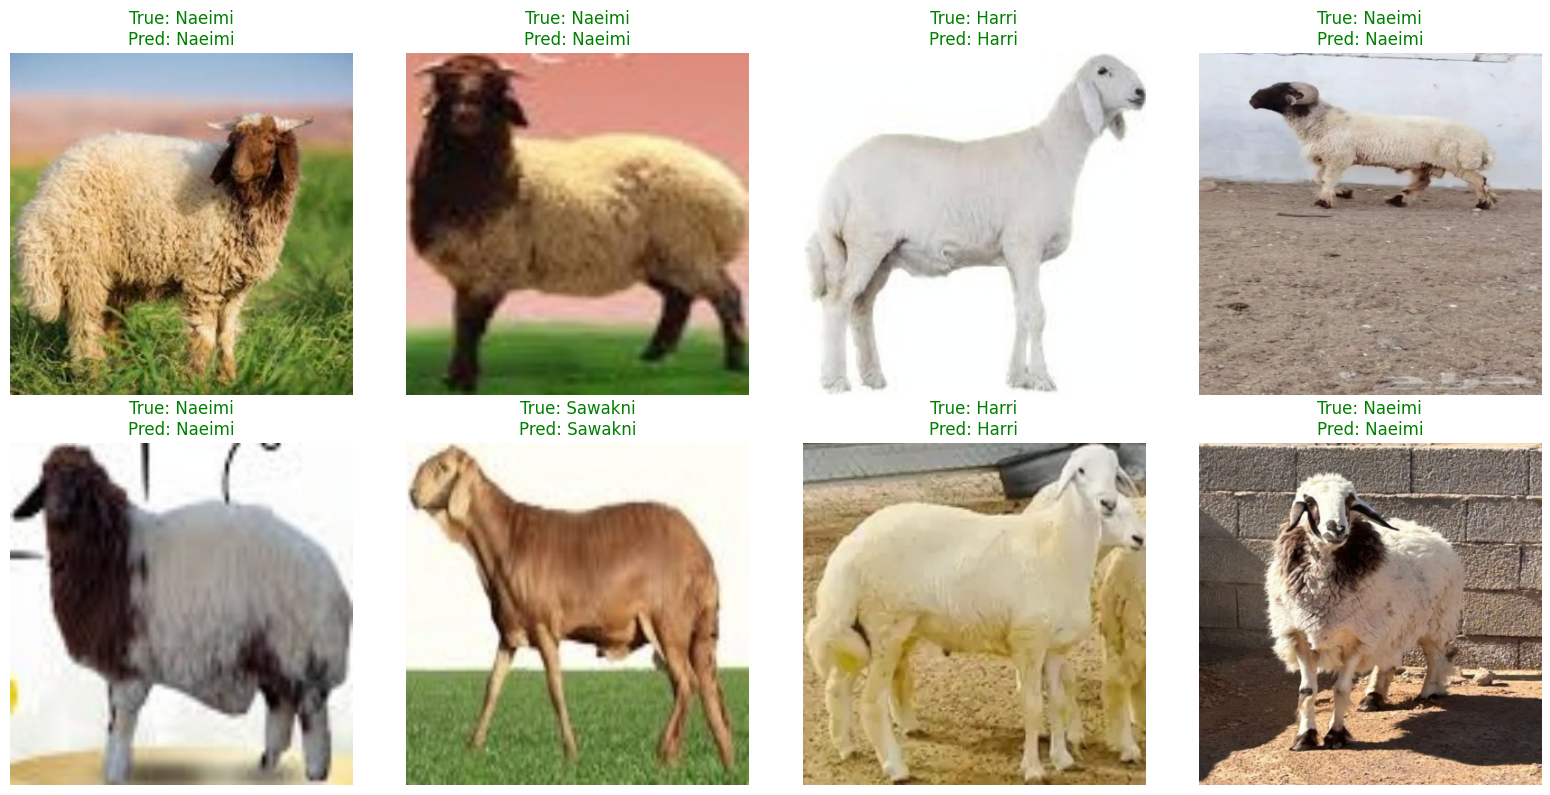


Preparing test predictions...


Generating TTA Predictions: 100%|██████████| 144/144 [00:12<00:00, 11.33it/s]


Submission file created: submission.csv
Shape: (144, 2)
Sample predictions:
       filename    label
0  6d66297e.jpg  Sawakni
1  ed9f6250.jpg   Naeimi
2  30503f9d.jpg    Harri
3  74b88387.jpg     Goat
4  385082b9.jpg     Goat
5  bb126871.jpg    Harri
6  85fe3a81.jpg  Sawakni
7  895567eb.jpg     Goat
8  acc9295b.jpg  Sawakni
9  b2be18b6.jpg  Sawakni

Prediction distribution:
label
Goat       36
Roman      26
Sawakni    26
Najdi      18
Naeimi     16
Barbari    12
Harri      10
Name: count, dtype: int64

Final Results:
Best Validation F1 Score: 0.9728
Total test predictions: 144
Class weights successfully applied to handle imbalanced dataset


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Configuration
class Config:
    # Paths - adjust these based on your Kaggle dataset structure
    DATA_PATH = '/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images'
    TRAIN_DIR = os.path.join(DATA_PATH, 'train')
    TEST_DIR = os.path.join(DATA_PATH, 'test')
    TRAIN_CSV = os.path.join(DATA_PATH, 'train_labels.csv')
    
    # Model parameters
    IMG_SIZE = 380
    BATCH_SIZE = 8
    NUM_EPOCHS = 75
    LEARNING_RATE = 1e-4 # Try lowering learning rates from 1e-4 to 5e-5 or even 3e-5
    NUM_CLASSES = 7
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Early stopping parameters
    EARLY_STOPPING_PATIENCE = 10
    MIN_DELTA = 0.001  # Minimum improvement to consider as progress
    
    # Breeds
    BREEDS = ['Naeimi', 'Najdi', 'Harri', 'Goat', 'Sawakni', 'Roman', 'Barbari']
    
    # New: Model name
    MODEL_NAME = 'efficientnet_b4' # <--- ADD THIS LINE

config = Config()

print(f"Using device: {config.DEVICE}")
print(f"Available breeds: {config.BREEDS}")

# Data Loading and Exploration
def load_and_explore_data():
    """Load and explore the training data"""
    print("Loading training data...")
    train_df = pd.read_csv(config.TRAIN_CSV)
    
    print(f"Training data shape: {train_df.shape}")
    print(f"Unique breeds: {train_df['label'].unique()}")
    print("\nBreed distribution:")
    print(train_df['label'].value_counts())
    
    # Visualize distribution
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    train_df['label'].value_counts().plot(kind='bar')
    plt.title('Breed Distribution')
    plt.xlabel('Breed')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    train_df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Breed Distribution (Percentage)')
    
    plt.tight_layout()
    plt.show()
    
    return train_df

# Custom Dataset Class
class SheepDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
        
        if not is_test:
            self.label_encoder = LabelEncoder()
            self.labels = self.label_encoder.fit_transform(self.df['label'])
            self.label_to_idx = {label: idx for idx, label in enumerate(self.label_encoder.classes_)}
            self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        filename = self.df.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, filename)
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image if loading fails
            image = Image.new('RGB', (config.IMG_SIZE, config.IMG_SIZE), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, filename
        else:
            label = self.labels[idx]
            return image, label

# Data Augmentation and Preprocessing
def get_transforms():
    """Define data augmentation and preprocessing transforms"""
    train_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def get_tta_transforms():
    """Define TTA transforms for test-time augmentation."""
    tta_transforms = [
        transforms.Compose([
            transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
            transforms.RandomHorizontalFlip(p=1.0), # Horizontal Flip
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
            transforms.RandomRotation(degrees=5), # Slight rotation
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        # Add more TTA variations if desired, e.g.,
        # transforms.Compose([
        #     transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
        #     transforms.ColorJitter(brightness=0.1, contrast=0.1),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        # ]),
    ]
    return tta_transforms




# Model Definition
# class SheepClassifier(nn.Module):
#     def __init__(self, num_classes=7, model_name='efficientnet_b4'):
#         super(SheepClassifier, self).__init__()
        
#         if model_name == 'efficientnet_b4':
#             self.backbone = models.efficientnet_b3(pretrained=True)
#             in_features = self.backbone.classifier[1].in_features
#             self.backbone.classifier = nn.Sequential(
#                 nn.Dropout(0.3),
#                 nn.Linear(in_features, 512),
#                 nn.ReLU(),
#                 nn.Dropout(0.3),
#                 nn.Linear(512, num_classes)
#             )
#         elif model_name == 'resnet50':
#             self.backbone = models.resnet50(pretrained=True)
#             in_features = self.backbone.fc.in_features
#             self.backbone.fc = nn.Sequential(
#                 nn.Dropout(0.3),
#                 nn.Linear(in_features, 512),
#                 nn.ReLU(),
#                 nn.Dropout(0.3),
#                 nn.Linear(512, num_classes)
#             )
        
#     def forward(self, x):
#         return self.backbone(x)

# Model Definition
class SheepClassifier(nn.Module):
    def __init__(self, num_classes=7, model_name='efficientnet_b4'): # Change default model_name, though it will be overridden by config.MODEL_NAME
        super(SheepClassifier, self).__init__()

        # Use the passed model_name from Config
        if model_name == 'efficientnet_b4': # <--- CHANGED FROM 'efficientnet_b3'
            # Correct way to load pre-trained weights in torchvision >= 0.13
            self.backbone = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1) # <--- UPDATED
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(in_features, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        elif model_name == 'efficientnet_b3': # Keep B3 as an option or remove if not needed
            self.backbone = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1) # <--- UPDATED
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(in_features, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        elif model_name == 'resnet50':
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1) # <--- UPDATED
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(in_features, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )

    def forward(self, x):
        return self.backbone(x)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False
        
    def __call__(self, val_score, model):
        if self.best_score is None:
            self.best_score = val_score
            self.save_checkpoint(model)
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    print('Restoring best weights')
                    model.load_state_dict(self.best_weights)
        else:
            self.best_score = val_score
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        '''Saves model when validation score improves.'''
        self.best_weights = model.state_dict().copy()

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, early_stopping=None):
    """Train the model with validation"""
    best_f1 = 0.0
    best_model_state = None
    train_losses = []
    val_losses = []
    val_f1_scores = []
    scaler = GradScaler()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(config.DEVICE), target.to(config.DEVICE)
            
            optimizer.zero_grad()
            with amp.autocast(): 
                output = model(data)
                loss = criterion(output, target)

            # Scale the loss and perform backward pass
            scaler.scale(loss).backward() # <--- CHANGE THIS LINE
            scaler.step(optimizer)       # <--- CHANGE THIS LINE
            scaler.update()              # <--- CHANGE THIS LINE
            # optimizer.zero_grad() # This is handled by the next iteration's optimizer.zero_grad() or at the end of loop

            running_loss += loss.item()
            
            if batch_idx % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(config.DEVICE), target.to(config.DEVICE)
                output = model(data)
                val_loss += criterion(output, target).item()
                
                _, predicted = torch.max(output.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Calculate F1 score
        f1 = f1_score(all_targets, all_preds, average='macro')
        val_f1_scores.append(f1)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}')
        print(f'  Val F1 Score: {f1:.4f}')
        
        # Save best model based on F1 score
        if f1 > best_f1:
            best_f1 = f1
            best_model_state = model.state_dict().copy()
            print(f'  New best F1 score: {best_f1:.4f}')

        # Early stopping check
        if early_stopping is not None:
            early_stopping(f1, model)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                print(f"Best F1 score was: {early_stopping.best_score:.4f}")
                break
        
        scheduler.step(f1)
        print(f'  Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        print('-' * 50)
    
    # Load best model (either from early stopping or best F1)
    if early_stopping is not None and early_stopping.best_weights is not None:
        model.load_state_dict(early_stopping.best_weights)
        final_f1 = early_stopping.best_score
    else:
        model.load_state_dict(best_model_state)
        final_f1 = best_f1
    
    return model, train_losses, val_losses, val_f1_scores, final_f1


def make_predictions(model, test_df, img_dir, label_encoder):
    """Make predictions on test set with Test-Time Augmentation (TTA)"""
    model.eval()
    tta_transforms = get_tta_transforms()
    predictions = []
    filenames = []

    for idx in tqdm(range(len(test_df)), desc="Generating TTA Predictions"):
        filename = test_df.iloc[idx]['filename']
        img_path = os.path.join(img_dir, filename)

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (config.IMG_SIZE, config.IMG_SIZE), (0, 0, 0))

        tta_outputs = []
        with torch.no_grad():
            for tta_transform in tta_transforms:
                augmented_image = tta_transform(image).unsqueeze(0).to(config.DEVICE)
                with amp.autocast(): # <--- ADD THIS FOR INFERENCE SPEED/MEMORY
                    output = model(augmented_image)
                # Convert output to float before softmax, as softmax usually expects float32
                tta_outputs.append(torch.softmax(output.float(), dim=1)) # <--- ADD .float()

        avg_output = torch.mean(torch.cat(tta_outputs, dim=0), dim=0)
        _, predicted_class_id = torch.max(avg_output, 0)

        pred_label = label_encoder.inverse_transform([predicted_class_id.item()])[0]

        predictions.append(pred_label)
        filenames.append(filename)

    return filenames, predictions
 

# Visualization Functions
def plot_training_history(train_losses, val_losses, val_f1_scores):
    """Plot training history"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot losses
    axes[0].plot(train_losses, label='Train Loss')
    axes[0].plot(val_losses, label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot F1 scores
    axes[1].plot(val_f1_scores, label='Validation F1', color='green')
    axes[1].set_title('Validation F1 Score')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('F1 Score')
    axes[1].legend()
    axes[1].grid(True)
    
    # Plot learning rate (if using scheduler)
    axes[2].set_title('Model Performance Summary')
    axes[2].text(0.1, 0.8, f'Best Validation F1: {max(val_f1_scores):.4f}', fontsize=12)
    axes[2].text(0.1, 0.6, f'Final Train Loss: {train_losses[-1]:.4f}', fontsize=12)
    axes[2].text(0.1, 0.4, f'Final Val Loss: {val_losses[-1]:.4f}', fontsize=12)
    axes[2].set_xlim(0, 1)
    axes[2].set_ylim(0, 1)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_sample_predictions(model, dataset, label_encoder, num_samples=8):
    """Visualize sample predictions"""
    model.eval()
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]
            
            # Make prediction
            image_batch = image.unsqueeze(0).to(config.DEVICE)
            output = model(image_batch)
            _, predicted = torch.max(output, 1)
            
            # Convert to breed names
            true_breed = label_encoder.inverse_transform([true_label])[0]
            pred_breed = label_encoder.inverse_transform(predicted.cpu().numpy())[0]
            
            # Denormalize image for display
            img_display = image.permute(1, 2, 0).numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            # Plot
            axes[i].imshow(img_display)
            axes[i].set_title(f'True: {true_breed}\nPred: {pred_breed}', 
                            color='green' if true_breed == pred_breed else 'red')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Main Pipeline
def main():
    """Main pipeline execution"""
    print("=== Sheep Classification Pipeline ===")
    print(f"Competition: Eid Al-Adha 2025 - Sheep Classification Challenge")
    print(f"Evaluation Metric: Macro F1 Score")
    print("=" * 50)
    
    # 1. Load and explore data
    train_df = load_and_explore_data()
    
    # 2. Calculate class weights for handling imbalanced dataset
    print("\nCalculating class weights for imbalanced dataset...")
    
    # Create temporary dataset to fit label encoder on full training data
    temp_dataset = SheepDataset(train_df, config.TRAIN_DIR, None, is_test=False)
    unique_labels = temp_dataset.label_encoder.classes_  # Get sorted list of all unique labels
    train_labels_numerical = temp_dataset.labels  # Get numerical labels from full dataframe
    
    # Calculate balanced class weights
    class_weights_array = compute_class_weight(
        class_weight='balanced',  # 'balanced' automatically computes inverse weights
        classes=np.unique(train_labels_numerical),  # Use the numerical labels
        y=train_labels_numerical
    )
    class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float).to(config.DEVICE)
    
    print("\nCalculated Class Weights:")
    for i, weight in enumerate(class_weights_array):
        print(f"  {temp_dataset.idx_to_label[i]}: {weight:.4f}")
    
    print(f"\nClass weight tensor shape: {class_weights_tensor.shape}")
    print(f"Weights will be applied to CrossEntropyLoss")
    
    # 3. Prepare transforms
    train_transform, val_transform = get_transforms()
    
    # 3. Create train/validation split
    train_split, val_split = train_test_split(
        train_df, 
        test_size=0.2, 
        stratify=train_df['label'], 
        random_state=42
    )
    
    print(f"Train split size: {len(train_split)}")
    print(f"Validation split size: {len(val_split)}")
    
    # 4. Create datasets and dataloaders
    train_dataset = SheepDataset(train_split, config.TRAIN_DIR, train_transform)
    val_dataset = SheepDataset(val_split, config.TRAIN_DIR, val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)
    
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    
    # 6. Initialize model
    model = SheepClassifier(num_classes=config.NUM_CLASSES, model_name=config.MODEL_NAME) # Ability to easy switch between models. 
    model = model.to(config.DEVICE)
    
    # 6. Define loss function, optimizer, and scheduler
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-4)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.NUM_EPOCHS)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=config.EARLY_STOPPING_PATIENCE // 2, verbose=True)
    
    print(f"Model: {config.MODEL_NAME}") 
    print(f"Optimizer: AdamW (lr={config.LEARNING_RATE})")
    print(f"Scheduler: ReduceLROnPlateau") 
    print(f"Loss function: CrossEntropyLoss (with class weights)") 
    
    # 8. Train model with early stopping
    print("\nStarting training with early stopping...")
    early_stopping = EarlyStopping(patience=config.EARLY_STOPPING_PATIENCE, 
                                   min_delta=config.MIN_DELTA, 
                                   restore_best_weights=True)
    
    model, train_losses, val_losses, val_f1_scores, best_f1 = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, 
        config.NUM_EPOCHS, early_stopping
    )
    
    # 9. Plot training history
    plot_training_history(train_losses, val_losses, val_f1_scores)
    
    # 10. Visualize sample predictions
    visualize_sample_predictions(model, val_dataset, train_dataset.label_encoder)
    
    # 11. Prepare test dataset
    print("\nPreparing test predictions...")
    test_files = [f for f in os.listdir(config.TEST_DIR) if f.endswith('.jpg')]
    test_df = pd.DataFrame({'filename': test_files})
    
    test_dataset = SheepDataset(test_df, config.TEST_DIR, val_transform, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)
    
    # 11. Make predictions function (now handles image loading internally)
    filenames, predictions = make_predictions(model, test_df, config.TEST_DIR, train_dataset.label_encoder)
    
    # 13. Create submission file
    submission_df = pd.DataFrame({
        'filename': filenames,
        'label': predictions
    })
    
    submission_df.to_csv('submission.csv', index=False)
    print(f"\nSubmission file created: submission.csv")
    print(f"Shape: {submission_df.shape}")
    print(f"Sample predictions:")
    print(submission_df.head(10))
    
    # 14. Display class distribution in predictions
    print(f"\nPrediction distribution:")
    print(submission_df['label'].value_counts())
    
    print(f"\nFinal Results:")
    print(f"Best Validation F1 Score: {best_f1:.4f}")
    print(f"Total test predictions: {len(predictions)}")
    print(f"Class weights successfully applied to handle imbalanced dataset")
    
    return model, submission_df, best_f1, class_weights_tensor

# Run the pipeline
if __name__ == "__main__":
    model, submission_df, best_f1, class_weights = main()
